### Subsample reference genome catalog

In [1]:
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.distance import DistanceMatrix

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_table('summary.txt.xz', index_col=0, header=0)
print('Total number of genomes: %d' % df.shape[0])
print('Metadata columns: %s' % ', '.join(list(df)))

Total number of genomes: 86200
Metadata columns: asm_name, assembly_accession, assembly_level, bioproject, biosample, ftp_path, genome_rep, infraspecific_name, isolate, organism_name, paired_asm_comp, refseq_category, release_type, score_faa, score_fna, score_rrna, score_trna, seq_rel_date, species_taxid, submitter, taxid, taxonomy, version_status, wgs_master, excluded_from_refseq, kingdom, phylum, class, order, family, genus, species, strain, combined_name, protein_count, protein_total_length, marker_count, marker_lineage, completeness, contamination, strain_heterogeneity, genome_size, #_ambiguous_bases, #_scaffolds, #_contigs, n50_scaffolds, n50_contigs, gc_scaffolds>1kbp, gc_std_scaffolds>1kbp), coding_density, translation_table, #_predicted_genes


#### Statistics

In [3]:
def hist_w_max(data, step, xmax):
    """Plot histogram with values > certain threshold combined in one bin."""
    bins = np.arange(0, xmax + step * 2, step)
    plt.xticks(step * np.arange(len(bins)), [str(x) for x in plt.hist(np.clip(data, bins[0],
        bins[-1]), bins=bins)[1]][:-1]+ ['Inf']);

In [4]:
def count_plot(data, percent=False, **kwargs):
    """Plot bars representing categorical counts."""
    ax = sns.countplot(data, **kwargs)
    total = float(len(data))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3,
                '{:1.2f}'.format(height / total) if percent else str(int(height)),
                ha='center')
    ax.set_xlabel('')
    return ax

In [5]:
mpl.rcParams['figure.figsize'] = (9.5, 2.5)

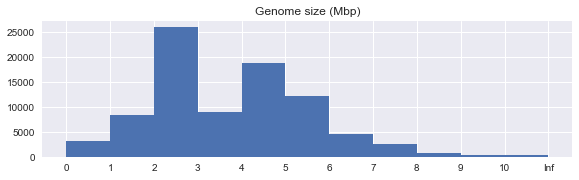

In [6]:
hist_w_max(df['genome_size'] / 1000000, 1, 10)
plt.title('Genome size (Mbp)');

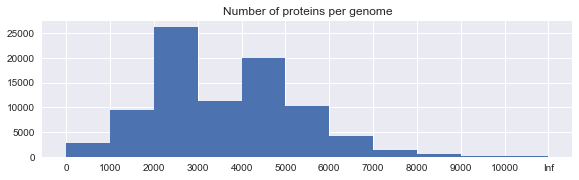

In [7]:
hist_w_max(df['protein_count'], 1000, 10000)
plt.title('Number of proteins per genome');

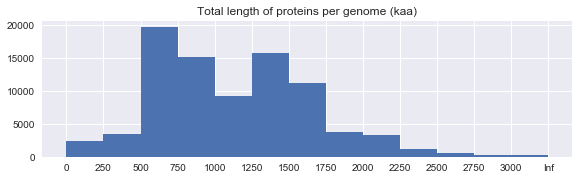

In [8]:
hist_w_max(df['protein_total_length'] / 1000, 250, 3000)
plt.title('Total length of proteins per genome (kaa)');

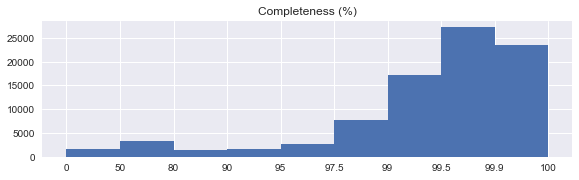

In [9]:
bins = [0, 50, 80, 90, 95, 97.5, 99, 99.5, 99.9, 100]
plt.bar(range(len(bins) - 1), np.histogram(df['completeness'], bins=bins)[0], width=1,
        align='edge')
plt.xticks(np.arange(len(bins)), [str(x) for x in bins])
plt.title('Completeness (%)');

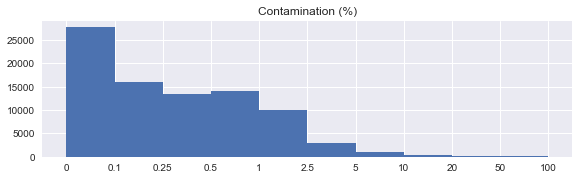

In [10]:
bins = [0, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 20, 50, 100]
plt.bar(range(len(bins) - 1), np.histogram(df['contamination'], bins=bins)[0], width=1,
        align='edge')
plt.xticks(np.arange(len(bins)), [str(x) for x in bins])
plt.title('Contamination (%)');

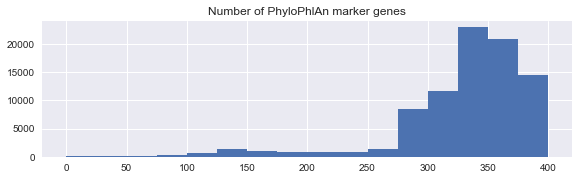

In [11]:
bins = np.arange(0, 425, 25)
plt.hist(df['marker_count'], bins=bins)
plt.title('Number of PhyloPhlAn marker genes');

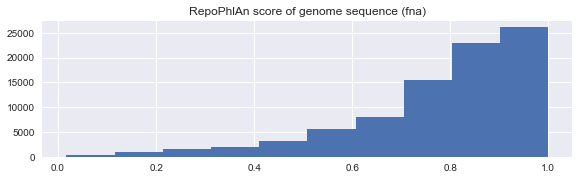

In [12]:
plt.hist(df['score_fna'])
plt.title('RepoPhlAn score of genome sequence (fna)');

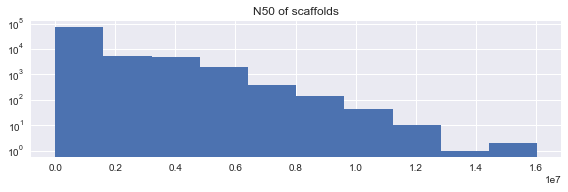

In [13]:
plt.hist(df['n50_scaffolds'], log=True)
plt.title('N50 of scaffolds');

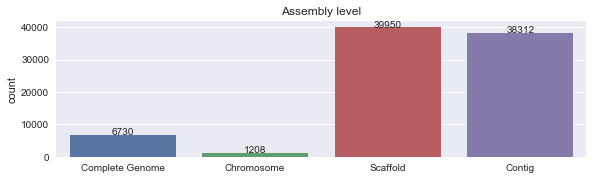

In [14]:
order=['Complete Genome', 'Chromosome', 'Scaffold', 'Contig']
count_plot(df['assembly_level'], order=order).set_title('Assembly level');

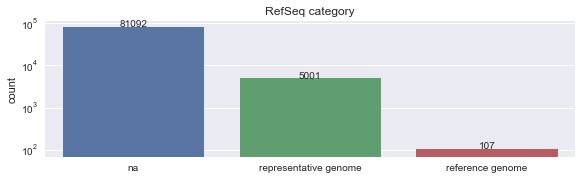

In [15]:
count_plot(df['refseq_category'], log=True).set_title('RefSeq category');

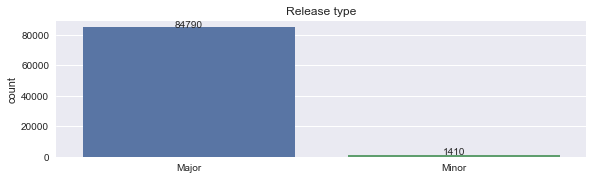

In [16]:
count_plot(df['release_type']).set_title('Release type');

In [17]:
ranks = ['phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']
df[ranks].describe()

,phylum,class,order,family,genus,species,strain
count,85672,81714,80829,80456,80413,86200,27080
unique,153,89,199,429,2117,20780,24966
top,Proteobacteria,Bacilli,Enterobacterales,Enterobacteriaceae,Streptococcus,Staphylococcus_aureus,Mycobacterium_abscessus_subsp_abscessus
freq,37109,25524,13496,11949,10454,7447,447


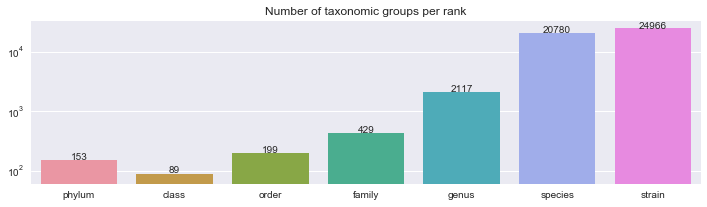

In [18]:
mpl.rcParams['figure.figsize'] = (12, 3)
n_taxa = df[ranks].apply(pd.Series.nunique)
ax = sns.barplot(x=n_taxa.index, y=n_taxa, log=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, str(int(height)), ha='center')
ax.set_xlabel('')
ax.set_title('Number of taxonomic groups per rank');

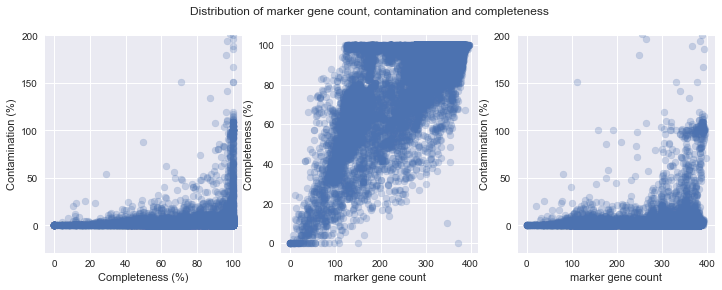

In [19]:
mpl.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(x='completeness', y='contamination', alpha=0.25, data=df)
axarr[0].set_ylim(ymax=200)
axarr[0].set_xlabel('Completeness (%)')
axarr[0].set_ylabel('Contamination (%)');
axarr[1].scatter(x='marker_count', y='completeness', alpha=0.25, data=df)
axarr[1].set_xlabel('marker gene count')
axarr[1].set_ylabel('Completeness (%)');
axarr[2].scatter(x='marker_count', y='contamination', alpha=0.25, data=df)
axarr[2].set_ylim(ymax=200)
axarr[2].set_xlabel('marker gene count')
axarr[2].set_ylabel('Contamination (%)')
plt.suptitle('Distribution of marker gene count, contamination and completeness');

### Criteria for subsampling

In [20]:
dm_fp = '/home/drz/Documents/WoL/subsample/prokaryotes.dm.bz2'
%time dm = DistanceMatrix.read(dm_fp)

Elapsed time: 1786.432 sec.


In [21]:
mpl.rcParams['figure.figsize'] = (12, 2.5)

In [22]:
def examine_set(genomes):
    """Plot statistics of chosen genomes."""
    gs = mpl.gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 2])
    cols = ['marker_count', 'completeness', 'contamination', 'score_fna']
    ymaxes = [400, 100, 600, 1.0]
    dfc = df[df.index.isin(genomes)]
    for i, col in enumerate(cols):
        ax = plt.subplot(gs[i])
        ax.plot(dfc[col].sort_values().tolist(), color='C%d' % i)
        ax.set_title(col)
        ax.set_ylim([0, ymaxes[i]])
    m_taxa = df[df.index.isin(genomes)][ranks].apply(pd.Series.nunique)
    p_taxa = m_taxa / n_taxa * 100
    ax = plt.subplot(gs[4])
    sns.barplot(x=p_taxa.index, y=p_taxa, ax=ax)
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, m_taxa[ranks[i]], ha='center')
    ax.set_ylim([0, 110])
    ax.set_xlabel('');
    ax.set_xticklabels(['p', 'c', 'o', 'f', 'g', 's', 't'])
    ax.set_title('% included')
    plt.tight_layout();

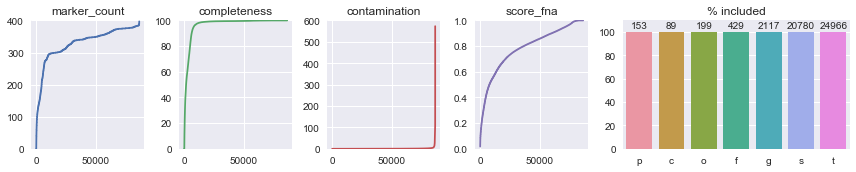

In [23]:
examine_set(df.index)

#### Quality filtering

85498


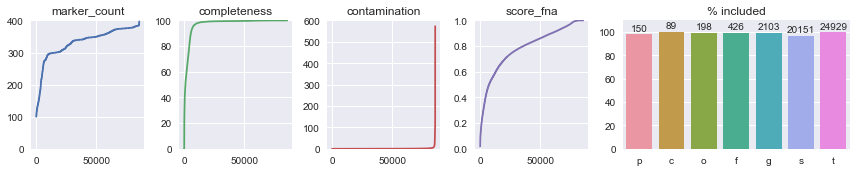

In [24]:
qualified = set(df.query('marker_count >= 100').index.tolist())
print('%d' % len(qualified))
examine_set(qualified)

85308


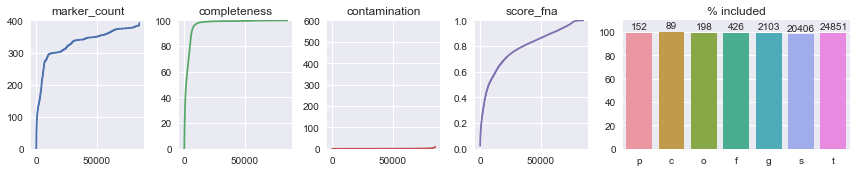

In [25]:
qualified = set(df.query('contamination <= 10').index.tolist())
print('%d' % len(qualified))
examine_set(qualified)

81291


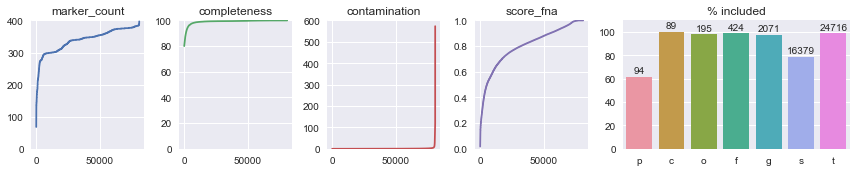

In [26]:
qualified = set(df.query('completeness >= 80').index.tolist())
print('%d' % len(qualified))
examine_set(qualified)

#### NCBI reference and representative genomes

5108


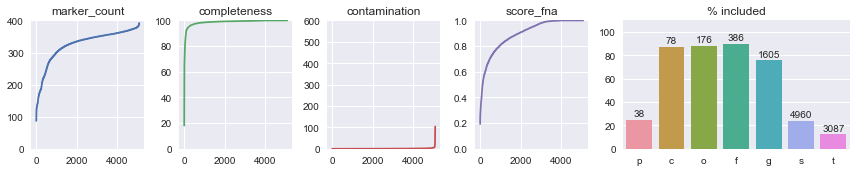

In [27]:
refp = set(df[df['refseq_category'] != 'na'].index.tolist())
print('%d' % len(refp))
examine_set(refp)

#### Only representatives of taxonomic groups

In [28]:
singles = {}
reports = []
for rank in ('phylum', 'class', 'order', 'family', 'genus', 'species'):
    single_taxa = [i for i, val in df[rank].value_counts().iteritems() if val == 1]
    singles[rank] = set(df[df[rank].isin(single_taxa)].index.tolist())
    reports.append('%s: %d' % (rank, len(singles[rank])))
print(', '.join(reports))

phylum: 11, class: 8, order: 29, family: 80, genus: 834, species: 18229


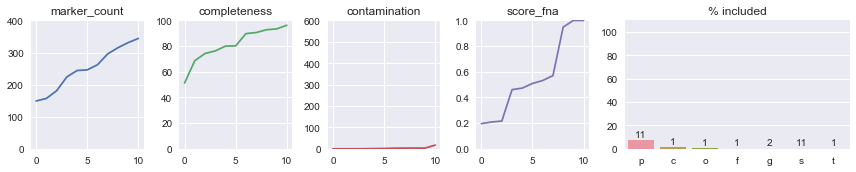

In [29]:
examine_set(singles['phylum'])

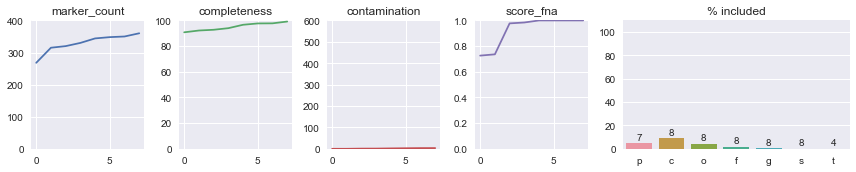

In [30]:
examine_set(singles['class'])

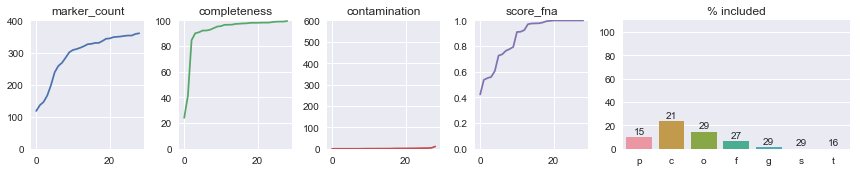

In [31]:
examine_set(singles['order'])

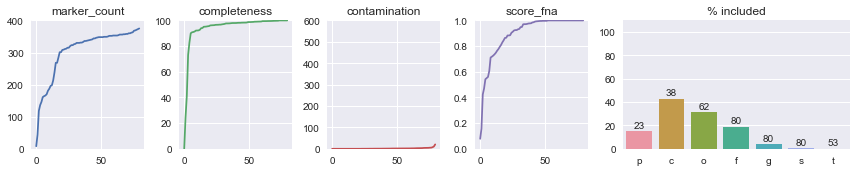

In [32]:
examine_set(singles['family'])

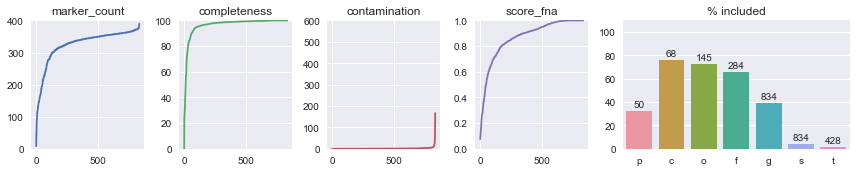

In [33]:
examine_set(singles['genus'])

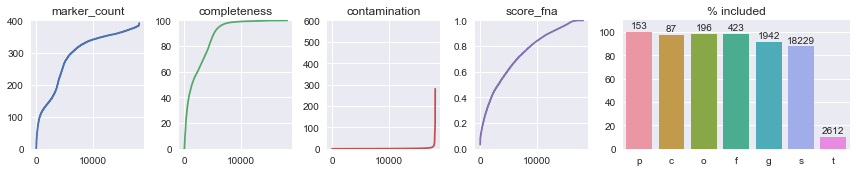

In [34]:
examine_set(singles['species'])

#### No defined taxonomy above species

519


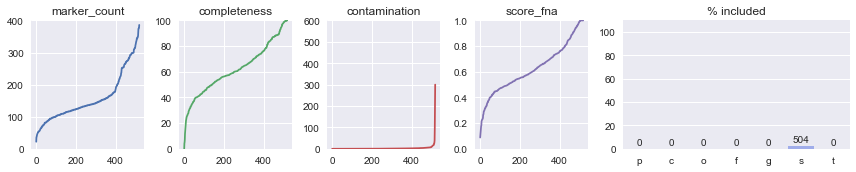

In [35]:
notax = set(df[df['phylum'].isnull() & df['class'].isnull() & df['order'].isnull()
               & df['family'].isnull() & df['genus'].isnull()].index.tolist())
print('%d' % len(notax))
examine_set(notax)

495


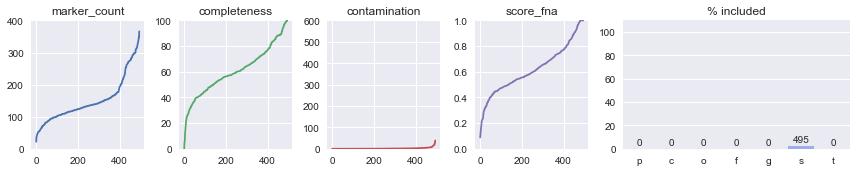

In [36]:
notax_spp = df[df.index.isin(notax)]['species']
single_spp = [i for i, val in notax_spp.value_counts().iteritems() if val == 1]
notax_single = set(notax_spp[notax_spp.isin(single_spp)].index.tolist())
print('%d' % len(notax_single))
examine_set(notax_single)

#### Prototype selection

In [37]:
def prototype_selection_destructive_maxdist(dm, num_prototypes, seedset=None):
    """Prototype selection function (minified)."""
    numRemain = len(dm.ids)
    currDists = dm.data.sum(axis=1)
    maxVal = currDists.max()
    if seedset is not None:
        for e in seedset:
            currDists[dm.index(e)] = maxVal * 2
    minElmIdx = currDists.argmin()
    currDists[minElmIdx], numRemain = np.infty, numRemain - 1
    while (numRemain > num_prototypes):
        currDists -= dm.data[minElmIdx]
        minElmIdx = currDists.argmin()
        currDists[minElmIdx], numRemain = np.infty, numRemain - 1
    return [dm.ids[idx]
            for idx, dist in enumerate(currDists)
            if dist != np.infty]

def distance_sum(elements, dm):
    """Calculate sum of distances among chosen genomes."""
    return np.tril(dm.filter(elements).data).sum()

In [ ]:
# number of prototypes to keep
k = 11000

In [38]:
%time prototypes = prototype_selection_destructive_maxdist(dm, k)
print('Sum of distances: %d.' % distance_sum(prototypes, dm))

Elapsed time: 18.446 sec.
Sum of distances: 60152796.


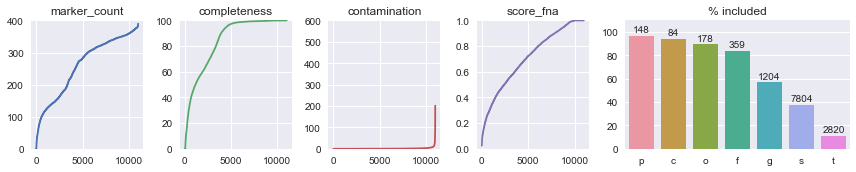

In [39]:
examine_set(prototypes)

### Subsampling plan A

 1. Exclude genomes with contamination > 10% or marker gene count < 100.
 2. Include NCBI reference and representative genomes.
 3. Include only representatives of each phylum to genus.
 4. Include only representatives of each species without defined lineage.
 5. Run prototype selection based on the MinHash distance matrix, with already included genomes as seeds, to obtain a total of 11000 genomes.
 6. For added prototypes with < 200 marker genes, swap them with the closest unselected genome in the MinHash space that have >= 200 marker genes.
 7. For each phylum to genus, and species without defined lineage, select one with highest marker gene count.

In [166]:
chosen = set()

#### Step 1: Exclude genomes with contamination > 10% or marker gene count < 100

84617


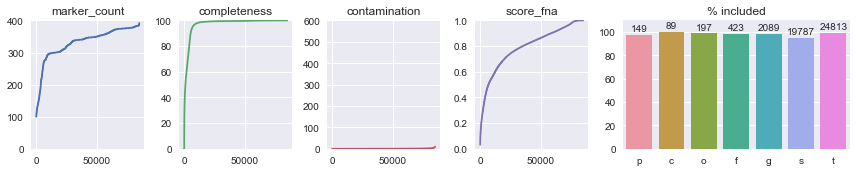

In [167]:
rule = 'contamination <= 10 and marker_count >= 100'
pool = set(df.query(rule).index.tolist())
print('%d' % len(pool))
examine_set(pool)

#### Step 2: Include NCBI reference and representative genomes

5082


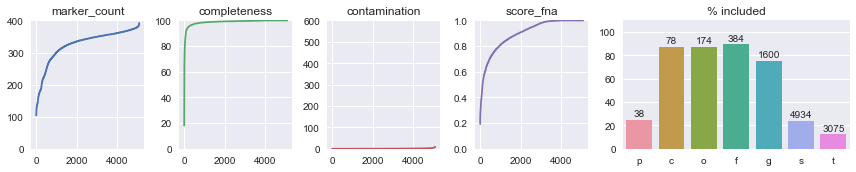

In [168]:
chosen.update(refp.intersection(pool))
print('%d' % len(chosen))
examine_set(chosen)

#### Step 3: Include only representatives of each phylum to genus

5450


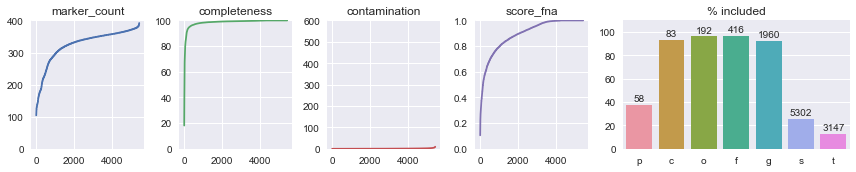

In [169]:
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    chosen.update(singles[rank].intersection(pool))
print('%d' % len(chosen))
examine_set(chosen)

#### Step 4: Include only representatives of each species without defined lineage

5829


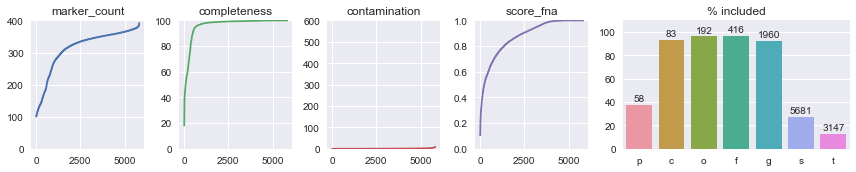

In [170]:
chosen.update(notax_single.intersection(pool))
print('%d' % len(chosen))
examine_set(chosen)

#### Step 5: Run prototype selection based on the MinHash distance matrix, with already included genomes as seeds, to obtain a total of 11000 genomes

In [171]:
%time dmf = dm.filter(pool)
len(dmf.ids)

CPU times: user 9min 8s, sys: 3min 23s, total: 12min 31s
Wall time: 15min 25s


84617

In [172]:
%time prototypes = prototype_selection_destructive_maxdist(dmf, 11000, chosen)
print('Sum of distances: %d.' % distance_sum(prototypes, dmf))

CPU times: user 6min 29s, sys: 1min 50s, total: 8min 19s
Wall time: 8min 19s
Sum of distances: 59434735.


In [173]:
added = set(prototypes) - chosen
len(added)

5171

11000


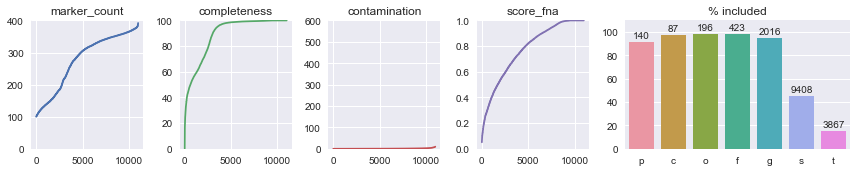

In [174]:
chosen.update(added)
print('%d' % len(chosen))
examine_set(chosen)

#### Step 6: For added prototypes with < 200 marker genes, swap them with the closest unselected genome in the MinHash space that have >= 200 marker genes

In [175]:
fewer = (dfp[dfp.index.isin(added)].query('100 <= marker_count < 200').index)
len(fewer)

2177

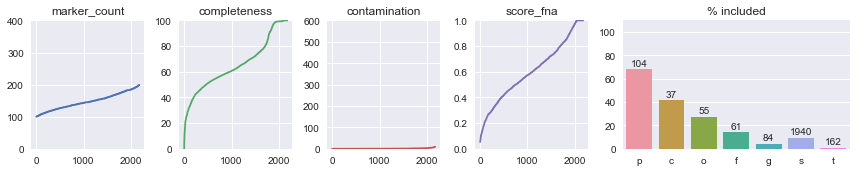

In [190]:
examine_set(fewer)

In [197]:
print('Reresented singletons:')
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    n = len([i for i, val in dfp[dfp.index.isin(fewer)][rank].value_counts().iteritems() if val == 1])
    print('%s: %d' % (rank, n))

Reresented singletons:
phylum: 12
class: 7
order: 14
family: 24
genus: 36


In [176]:
%time dma = dmf.filter(added)

CPU times: user 26.8 s, sys: 7.25 s, total: 34.1 s
Wall time: 34 s


Radius for swapping: <= 1/2 of the distance from the closest selected genome

In [178]:
%time radii = {g: sorted(dma[g])[1] / 2 for g in fewer}

CPU times: user 2.46 s, sys: 4 ms, total: 2.46 s
Wall time: 2.46 s


For each prototype, iterate unselected genomes within the radius from close to distant, until reaching one with >= 200 marker genes.

In [180]:
src2dst = {}  # source => destination pairs for swapping
dsts = set()
for src in fewer:
    for dst, val in pd.Series(dmf[src], index=dmf.ids).sort_values()[1:].iteritems():
        if val > radii[src]:
            break
        if dst in chosen:
            continue
        if dst in dsts:
            continue
        if dfp['marker_count'][dst] >= 200:
            src2dst[src] = dst
            dsts.add(dst)
            break
print('Swapped genomes: %d' % len(src2dst))
for src, dst in src2dst.items():
    print('%s (%d) => %s (%d)' % (src, dfp['marker_count'][src], dst,
                                  dfp['marker_count'][dst]))

Swapped genomes: 27
G000375385 (133) => G000377185 (367)
G000397805 (111) => G000402215 (202)
G000402795 (196) => G000402815 (225)
G000403885 (151) => G000403865 (251)
G000405325 (141) => G000494265 (248)
G000405625 (177) => G000402595 (267)
G000497815 (185) => G001868765 (257)
G000634355 (196) => G000634915 (272)
G000634675 (129) => G000634335 (281)
G000635575 (137) => G000634095 (294)
G001431125 (147) => G001417715 (279)
G001509075 (166) => G001508995 (289)
G001703975 (133) => G001704065 (286)
G001725305 (155) => G001897435 (355)
G001768885 (176) => G001767775 (208)
G001775995 (105) => G001296435 (384)
G001781875 (155) => G001781125 (202)
G001798055 (129) => G001798885 (336)
G001801235 (121) => G001801175 (345)
G001914855 (148) => G001914475 (263)
G001917575 (174) => G001918505 (210)
G001917705 (160) => G001918665 (300)
G001918525 (139) => G001914625 (280)
G001919515 (115) => G001918485 (314)
G001983465 (102) => G001983555 (284)
G002011845 (162) => G002010915 (347)
G900079125 (199) =

In [187]:
chosen = (chosen - set(src2dst)).union(dsts)

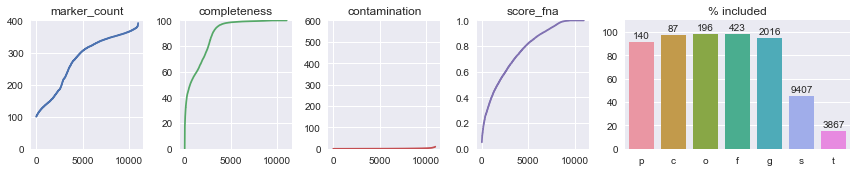

In [188]:
examine_set(chosen)

#### Step 7: For each phylum to genus, and species without defined lineage, select one with highest marker gene count

Added taxa:
phylum: 9
class: 1
order: 1
family: 0
genus: 73
11084


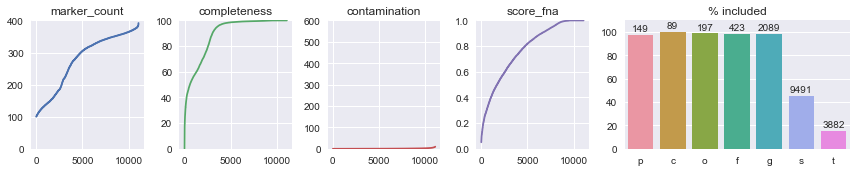

In [189]:
print('Added taxa:')
dfc = df[df.index.isin(chosen)]
dfp = df[df.index.isin(pool)]
for rank in ('phylum', 'class', 'order', 'family', 'genus'):
    toadd = set()
    chosen_taxa = dfc[rank].dropna().unique()
    for taxon in dfp[rank].dropna().unique():
        if not taxon in chosen_taxa:
            toadd.add(dfp[dfp[rank] == taxon]['marker_count'].idxmax())
    print('%s: %s' % (rank, len(toadd)))
    chosen.update(toadd)
    dfp = dfp[~dfp.index.isin(toadd)]
print('%d' % len(chosen))
examine_set(chosen)

In [203]:
dfc = df[df.index.isin(chosen)]
dfc['marker_count'].describe()

count    11084.000000
mean       279.047546
std         85.286787
min        100.000000
25%        201.000000
50%        315.000000
75%        349.000000
max        392.000000
Name: marker_count, dtype: float64

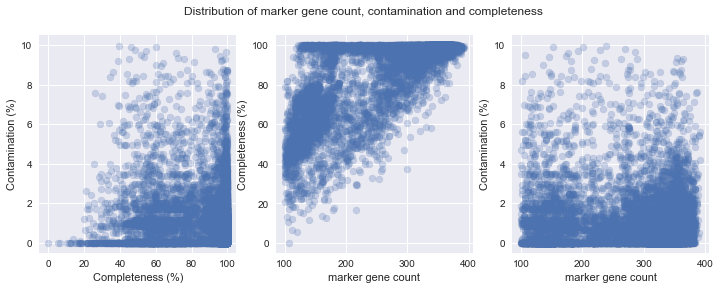

In [205]:
mpl.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(x='completeness', y='contamination', alpha=0.25, data=dfc)
axarr[0].set_xlabel('Completeness (%)')
axarr[0].set_ylabel('Contamination (%)');
axarr[1].scatter(x='marker_count', y='completeness', alpha=0.25, data=dfc)
axarr[1].set_xlabel('marker gene count')
axarr[1].set_ylabel('Completeness (%)');
axarr[2].scatter(x='marker_count', y='contamination', alpha=0.25, data=dfc)
axarr[2].set_xlabel('marker gene count')
axarr[2].set_ylabel('Contamination (%)')
plt.suptitle('Distribution of marker gene count, contamination and completeness');

#### Export results

In [202]:
with open('chosen.txt', 'w') as f:
    for g in sorted(chosen):
        f.write('%s\n' % g)

In [207]:
df['chosen'] = df.index.isin(chosen)

In [210]:
df.to_csv('summary_chosen.tsv', sep='\t')